# Guided Data Challenge Part II: Generative Modeling

Author:
 - [@EiffL](https://github.com/EiffL) (Fancois Lanusse)
 
## Overview

In this notebook, we will go over several types of generative models which can be used to learn priors in order to solve the inverse problems illustrated in the previous notebook. Concretely, we will see how to fit a model $p_{\theta}(x)$ to existing data.


### Learning objectives:

In this notebook we will put into practice:
  - Write a Neural Network with DeepMind's Haiku
  - Build a Variational Auto-Encoder
  - Build a latent Normalizing Flow 
  - (Bonus) Build a score matching network!


In [1]:
%pylab inline
import jax
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


## Step I: Preparing training data


Here we will be using the space-based data and try to learn a generative model from it.

In [3]:
import quarks2cosmos
import tensorflow_datasets as tfds
import tensorflow as tf

def augment_data(example):
    """ This applies random flipping to the input image.
    """
    x = example['image']
    x = x[...,tf.newaxis]
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = x[..., 0]
    return x 

dset = tfds.load('Cosmos/23.5', split=tfds.Split.TRAIN)
dset = dset.cache()
dset = dset.repeat()
dset = dset.shuffle(50000)
dset = dset.batch(64)
dset = dset.map(augment_data)
dset = iter(tfds.as_numpy(dset))

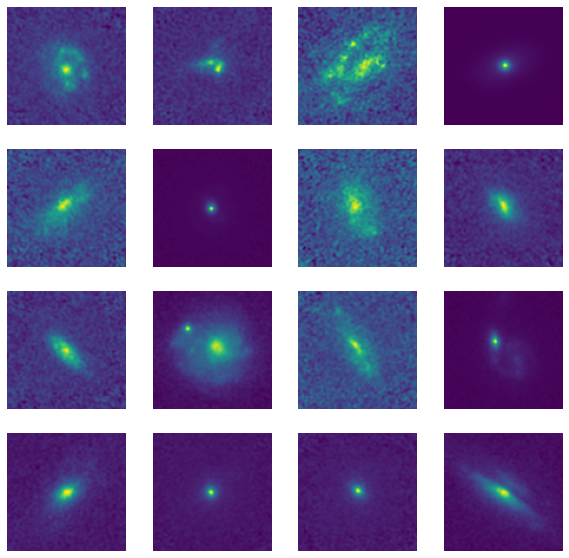

In [4]:
batch = next(dset)

figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(batch[i])
    axis('off')    

## Step II: Building a Variational Auto-Encoder

We will start by a conventional Variational Auto-Encoder, this model here is not very complicated, probably the most simple one you could think of. 

It is an opportunity to see how to build a neural network in Haiku, and feel free to try to improve the model :-) 

In [6]:
# Let's start with the imports
import haiku as hk     # NN library
import optax           # Optimizer library
import pickle

# Utility function for tensoboard
from flax.metrics import tensorboard

# TensorFlow probability
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [7]:
# Create a random sequence
rng_seq = hk.PRNGSequence(42)

#### Building an encoder

In [8]:
class Encoder(hk.Module):
  """Simple Convolutional encoder model."""
  def __init__(self, latent_size=64):
    super().__init__()
    self._latent_size = latent_size

  def __call__(self, x):
    # Add channel dimension to x
    x = x[..., jnp.newaxis]
    
    x = hk.Conv2D(16, kernel_shape=3)(x)
    x = jax.nn.leaky_relu(x)
    x = hk.avg_pool(x, window_shape=3, strides=2, padding='SAME')
    
    x = hk.Conv2D(32, kernel_shape=3)(x)
    x = jax.nn.leaky_relu(x)
    x = hk.avg_pool(x,  window_shape=3, strides=2, padding='SAME')
    
    x = hk.Conv2D(64, kernel_shape=3)(x)
    x = jax.nn.leaky_relu(x)
    x = hk.avg_pool(x, window_shape=3, strides=2, padding='SAME')
    
    x = hk.Conv2D(128, kernel_shape=3)(x)
    x = jax.nn.leaky_relu(x)
    x = hk.avg_pool(x, window_shape=3, strides=2, padding='SAME')
    
    x = hk.Conv2D(128, kernel_shape=3)(x)
    x = jax.nn.leaky_relu(x)
    x = hk.avg_pool(x, window_shape=3, strides=2, padding='SAME')
    
    x = hk.Flatten()(x)
    
    x = hk.Linear(256)(x)
    x = jax.nn.leaky_relu(x)
    
    # Returns the variational distribution encoding the input image
    loc = hk.Linear(self._latent_size)(x)
    
    scale = jax.nn.softplus(hk.Linear(self._latent_size)(x)) + 1e-3
    return tfd.MultivariateNormalDiag(loc, scale)                    # Note that this returns a distribution !

In [9]:
# Transform the model into pure functions
encoder = hk.without_apply_rng(hk.transform(lambda x : Encoder()(x)))

What `hk.transform` returns is a structure that contains two functions:
  - `model.init`: A function that initializes the parameters 
  - `model.apply`: A function that applies the neural network 

Let's start by creating params:

In [10]:
params_enc = encoder.init(next(rng_seq), jnp.zeros([1,101,101]))

And then you apply the NN like this:

In [11]:
z = encoder.apply(params_enc, jnp.zeros([1,101,101]))

In [12]:
z

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[1] event_shape=[64] dtype=float32>

and what is returned is an actual distribution object :-) So you can sample from it and evaluate probability.

#### Building a decoder

In [13]:
class Decoder(hk.Module):
  """Simple Convolutional decoder model."""
  def __call__(self, z, scale=1.0):
    
    # Reshape latent variable to an image
    x = hk.Linear(256)(z)
    x = jax.nn.leaky_relu(x)
    
    x = hk.Linear(3*3*128)(x)
    x = x.reshape([-1,3,3,128])
    
    x = hk.Conv2DTranspose(128, kernel_shape=3, stride=2)(x)
    x = jax.nn.leaky_relu(x)
    
    x = hk.Conv2DTranspose(64, kernel_shape=3, stride=2)(x)
    x = jax.nn.leaky_relu(x)
    
    x = hk.Conv2DTranspose(32, kernel_shape=3, stride=2)(x)
    x = jax.nn.leaky_relu(x)
    
    x = hk.Conv2DTranspose(16, kernel_shape=3, stride=2)(x)
    x = jax.nn.leaky_relu(x)
    
    x = hk.Conv2DTranspose(8, kernel_shape=3, stride=2)(x)
    
    x = hk.Conv2D(1, kernel_shape=5)(x)
    
    x = x[...,0]
    x = jnp.pad(x, [[0,0],[3,2],[3,2]])  # This step is to pad the image for the 101x101 expected size
    
    return tfd.Independent(tfd.Normal(loc=x, scale=scale), reinterpreted_batch_ndims=2)

In [14]:
# We turn the model into pure functions
decoder = hk.without_apply_rng(hk.transform(lambda z : Decoder()(z)))

In [15]:
# Create parameters
params_dec = decoder.init(next(rng_seq), jnp.zeros([1,64]))

In [16]:
decoder.apply(params_dec, jnp.zeros([1,64]))

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[1] event_shape=[101, 101] dtype=float32>

#### Building the auto-encoder

In [17]:
# Combine both set of parameters
params = hk.data_structures.merge(params_enc, params_dec)

In [18]:
@jax.jit
def loss_fn(params, rng_key, batch):
    x = batch
    
    # Autoencode an example
    q = encoder.apply(params, x)

    # Sample from the posterior
    z = q.sample(seed=rng_key)
    
    # Decode the sample
    p = decoder.apply(params, z)
    
    # Compute loss
    kl = tfd.kl_divergence(q, tfd.MultivariateNormalDiag(jnp.zeros(64),
                                                         scale_identity_multiplier=1.))
    log_likelihood = p.log_prob(x)

    elbo = log_likelihood - 0.0001*kl      # Here we apply a factor on the KL term, you can try to change it!
    return -jnp.mean(elbo)

In [19]:
def lr_schedule(step):
  """Linear scaling rule optimized for 90 epochs."""
  steps_per_epoch = 40000 // 64 

  current_epoch = step / steps_per_epoch  # type: float
  boundaries = jnp.array((20, 40, 60)) * steps_per_epoch
  values = jnp.array([1., 0.1, 0.01, 0.001])

  index = jnp.sum(boundaries < step)
  return jnp.take(values, index)

In [20]:
optimizer = optax.chain(
      optax.adam(1e-3),
      optax.scale_by_schedule(lr_schedule))

opt_state = optimizer.init(params)

In [21]:
@jax.jit
def update(params, rng_key, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [22]:
# To keep a log of training loss
summary_writer = tensorboard.SummaryWriter("models/vae")
step = 0

In [24]:
# Before starting the training, we can start tensorboard to check on the training
# Hummm not working on PSC, if anyone has an idea of how to make this work....
# %load_ext tensorboard
# %tensorboard --logdir models

In [ ]:
for s in range(50000):
    loss, params, opt_state = update(params, next(rng_seq), opt_state, next(dset))
    step+=1
    
    summary_writer.scalar('train_loss', loss, step)
    summary_writer.scalar('learning_rate', lr_schedule(step)*1e-3, step)
    
    if step%5000 ==0:
        with open('models/vae/model-%d.pckl'%step, 'wb') as file:
            pickle.dump([params, opt_state], file)

In [48]:
# If I wanted to reload a specific outputed set of params I can use the following:
# with open('models/vae/model-5000.pckl', 'rb') as file:
#     params, opt_state = pickle.load(, file)

Now let's quickly test the auto-encoder

In [163]:
# Retrieving a batch of data
batch = next(dset)

In [164]:
# Use the encoder to get the variational posterior distribution
latent_distribution = encoder.apply(params, batch)

In [165]:
# Sample some variables from the distribution
z = latent_distribution.sample(seed=next(rng_seq))

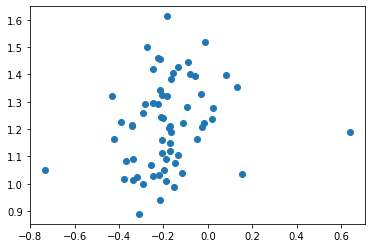

In [166]:
scatter(z[:,0], z[:,1])

In [171]:
# And we can now get the data likelihood given latent variables 
likelihood = decoder.apply(params, z)

In [172]:
# We will look at the mean of the data likelihood
reconstruction = likelihood.mean()

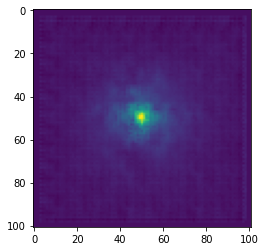

In [173]:
imshow(reconstruction[0])

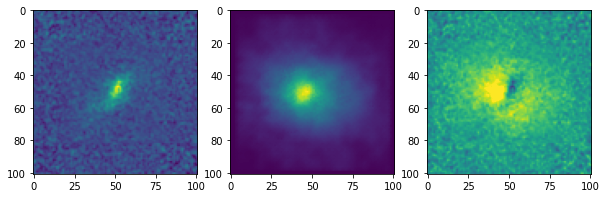

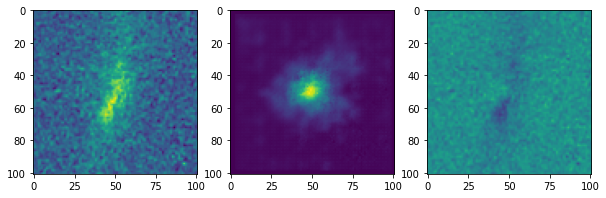

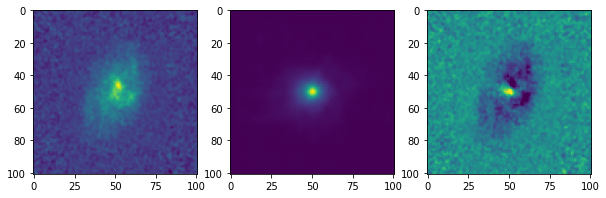

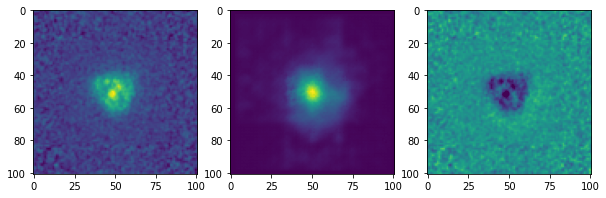

In [174]:
# Let's draw from a few examples
for i in range(4):
    figure(figsize=[10,5])
    subplot(131)
    imshow(batch[i,:,:])
    subplot(132)
    imshow(im[i,:,:],vmin=0)
    subplot(133)
    imshow(im[i,:,:] - batch[i,:,:],vmin=-.03,vmax=0.03)

Now, it's your turn! Try to get the best possible (Variational)-Auto-Encoder.

But first let's check something, we see that the autoencoding is not perfect but can we at least sample from it!?

In [217]:
latent_prior = tfd.MultivariateNormalDiag(jnp.zeros(64))
z_prior = latent_prior.sample(64, seed=next(rng_seq))

likelihood = decoder.apply(params, z_prior)
rec = likelihood.mean()

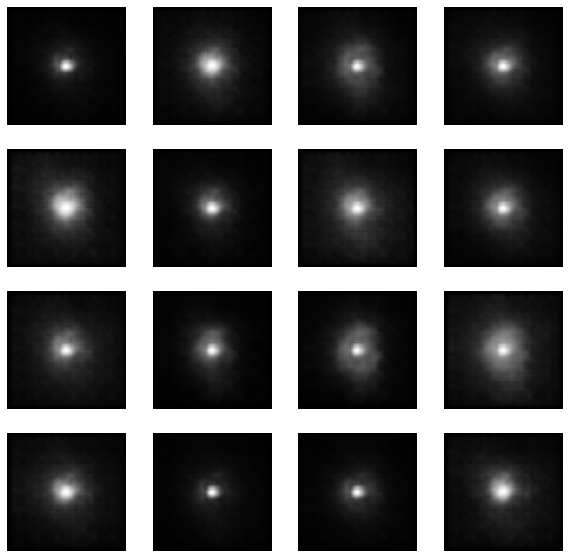

In [218]:
figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        subplot(4,4,i+4*j+1)
        imshow(rec[i+4*j],cmap='gray')
        axis('off')

## Step III: Latent Normalizing Flow

Even with a very good VAE, the latent space of the VAE is rarely very Gaussian, which means that it can be hard to sample realistic images from it. In this part of the notebook, we'll see how you can create a latent model using a Normalizing Flow, which will learn how to sample from the effective latent distribution.





In [108]:
# Let's store the dimensionality of our latent space
d = 64

The first part of a Normalizing Flow is to define some coupling layers, i.e. the layers of the Flow.

In [109]:
class AffineCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __init__(self, scale_only=True, **kwargs):
    super().__init__(**kwargs)
    self.scale_only = scale_only

  def __call__(self, x, output_units, **condition_kwargs):
    net = hk.Linear(128)(x)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net)
    shifter = tfb.Shift(hk.Linear(output_units)(net))
    if self.scale_only:
      return shifter
    else:
      scaler = tfb.Scale(jnp.clip(jax.nn.softplus(hk.Linear(output_units)(net)), 1e-2, 1e1))
      return tfb.Chain([shifter, scaler])

With these layers we can then compose the flow:

In [112]:
class AffineFlow(hk.Module):
    """This is a normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
        chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(name='aff1')),
            tfb.Permute(np.arange(d)[::-1]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(name='aff2')),
            tfb.Permute(np.arange(d)[::-1]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(name='aff3',
                                                         scale_only=False)),
            tfb.Permute(np.arange(d)[::-1]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(name='aff4',
                                                         scale_only=False)),
            tfb.Permute(np.arange(d)[::-1]),
        ])
        
        nvp = tfd.TransformedDistribution(
            tfd.MultivariateNormalDiag(jnp.zeros(d),jnp.ones(d)),
            bijector=chain)
        return nvp

We can now define two types of functions, one that will evaluate the log likelihood, and one that will sample from the flow.

In [191]:
model_logp = hk.without_apply_rng(hk.transform(lambda x : AffineFlow()().log_prob(x)))
model_sample = hk.transform(lambda n : AffineFlow()().sample(n, seed=hk.next_rng_key()))

In [192]:
params_flow = model_logp.init(next(rng_seq), jnp.zeros([1, d]))

In [193]:
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params_flow)

In [194]:
@jax.jit
def loss_fn(params_flow, rng_key, batch):
    x = batch

    # Encode example using the trained encoder
    # params here are the params of the VAE as trained in the 
    q = encoder.apply(params, x)
    
    z = q.sample(seed=rng_key)

    logp = model_logp.apply(params_flow, z)
    
    return -jnp.mean(logp)

In [195]:
@jax.jit
def update(params, rng_key, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [196]:
summary_writer = tensorboard.SummaryWriter("models/flow")

In [197]:
step = 0

In [ ]:
for s in range(10000):
    loss, params_flow, opt_state = update(params_flow, next(rng_seq), opt_state, next(dset))
    step+=1
    if step % 100 == 0:
        summary_writer.scalar('train_loss', loss, step)
        print(step, loss)

In [220]:
# Once trained, we can apply the flow and check how we're doing
batch = next(dset)

In [221]:
latent_distribution = encoder.apply(params, batch)
z = latent_distribution.sample(seed=next(rng_seq))

In [222]:
# And also sample from the Flow
z2 = model_sample.apply(params_flow, next(rng_seq), n=256)

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5770: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


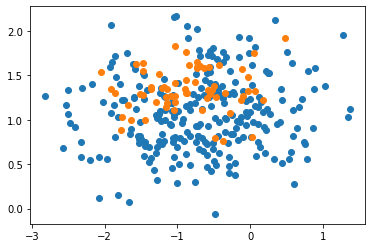

In [223]:
scatter(z2[:,0],  z2[:,1], label='Flow latent')
scatter(z[:,0],  z[:,1], label='VAE latent')

Here we see that the 2 distributions don't match very well, more training is necessary

#### Combining the VAE with the Flow

We can now combine both models, the flow allowing us to sample from the latent space of the VAE, and then we decode these samples with the decoder of the VAE:

In [224]:
# Sample latent space values with the flow
z = model_sample.apply(params_flow, next(rng_seq), n=256)
# Decode them with the Decoder
likelihood = decoder.apply(params, z)
rec = likelihood.mean()

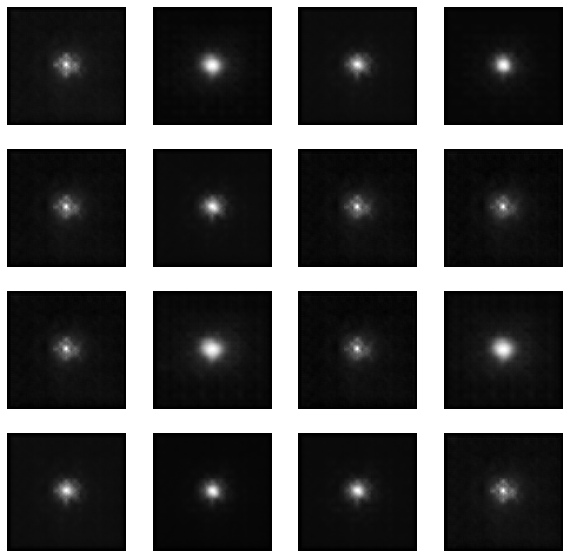

In [225]:
figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        subplot(4,4,i+4*j+1)
        imshow(rec[i+4*j],cmap='gray')
        axis('off')

## Bonus:  Denoising Score Matching

In this section, we will now explore how to use Denoising Score Matching to learn a Generative Model.


In [605]:
# Training set preparation
def load_dataset(batch_size, noise_dist_std, train_split):

  def pre_process(im):
    """ Pre-processing function preparing data for denoising task
    """
    # Cutout a portion of the map
    x = tf.image.resize_with_crop_or_pad(im['image'][...,tf.newaxis], 128,128)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    # Sample random Gaussian noise
    u = tf.random.normal(tf.shape(x))
    # Sample standard deviation of noise corruption
    s = noise_dist_std * tf.random.normal((1, 1, 1))
    # Create noisy image
    y = x + s * u
    return {'x':x, 'y':y, 'u':u,'s':s}

  ds = tfds.load('Cosmos/23.5', split=train_split, shuffle_files=True)
  ds = ds.shuffle(buffer_size=10*batch_size)
  ds = ds.repeat()
  ds = ds.map(pre_process)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds.as_numpy_iterator()

In [606]:
cosmos_dset = load_dataset(32, 0.025, tfds.Split.TRAIN)
batch = next(cosmos_dset)

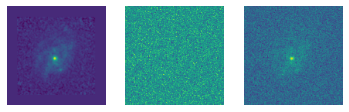

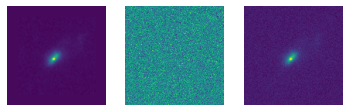

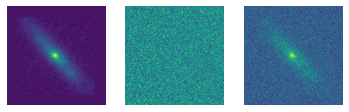

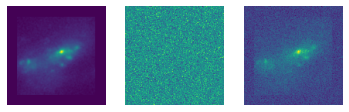

In [608]:
for i in range(4):
    figure()
    subplot(131)
    imshow(batch['x'][i])
    axis('off')
    subplot(132)
    imshow(batch['u'][i])
    axis('off')
    subplot(133)
    imshow(batch['y'][i])
    axis('off')

In [609]:
# Ok, so now we just need to train 
from quarks2cosmos.models import SmallUResNet, SNParamsTree
import haiku as hk
import optax

In [610]:
model = hk.transform_with_state(lambda x, sigma, is_training=False: SmallUResNet()(x, sigma, is_training))

In [611]:
params, state = model.init(jax.random.PRNGKey(0), jnp.zeros([1,128,128,1]),jnp.zeros([1,1,1,1]), is_training=True)

In [612]:
def lr_schedule(step):
  """Linear scaling rule optimized for 90 epochs."""
  steps_per_epoch = 40000 // 32

  current_epoch = step / steps_per_epoch  # type: float
  lr = (1.0 * 32) / 32
  boundaries = jnp.array((20, 40, 60)) * steps_per_epoch
  values = jnp.array([1., 0.1, 0.01, 0.001]) * lr

  index = jnp.sum(boundaries < step)
  return jnp.take(values, index)

In [613]:
optimizer = optax.chain(
  optax.adam(learning_rate=1e-3),
  optax.scale_by_schedule(lr_schedule)
)
rng_seq = hk.PRNGSequence(42)

In [614]:
opt_state = optimizer.init(params)

In [615]:
sn_fn = hk.transform_with_state(lambda x: SNParamsTree(ignore_regex='[^?!.]*b$|[^?!.]*offset$',
                                                          val=1.)(x))

In [616]:
_, sn_state = sn_fn.init(next(rng_seq), params)

In [617]:
params, sn_state = sn_fn.apply(None, sn_state, None, params)

In [618]:
def loss_fn(params, state, rng_key, batch):
    score, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=True)
    loss = jnp.mean((batch['u'] + batch['s'] * (score))**2)
    return loss, state

In [619]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    return loss, new_params, state, new_sn_state, new_opt_state

In [621]:
from flax.metrics import tensorboard
import pickle

In [622]:
summary_writer = tensorboard.SummaryWriter('score_model_0.025')

In [ ]:
for step in range(100000):
    loss, params, state, sn_state, opt_state = update(params, state, sn_state,
                                                      next(rng_seq), opt_state,
                                                      next(cosmos_dset))
    summary_writer.scalar('train_loss', loss, step)
    summary_writer.scalar('learning_rate', lr_schedule(step)*1e-3, step)
    
    if step%5000 ==0:
        with open('score_model_0.025/model-%d.pckl'%step, 'wb') as file:
            pickle.dump([params, state, sn_state], file)

In [624]:
def score_fn(y, s):
    score, _ = model.apply(params, state, None, y, s.reshape((-1,1,1,1)), is_training=False)
    return score

In [625]:
score = score_fn(batch['y'], batch['s'])

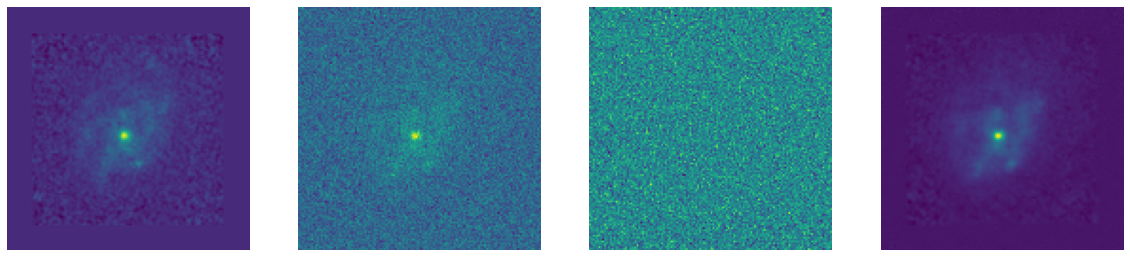

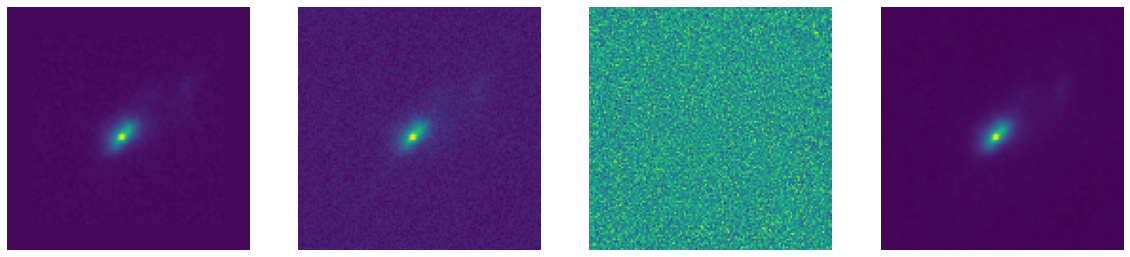

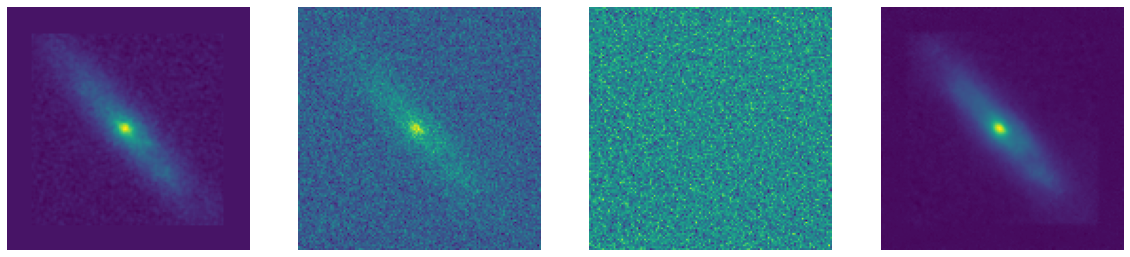

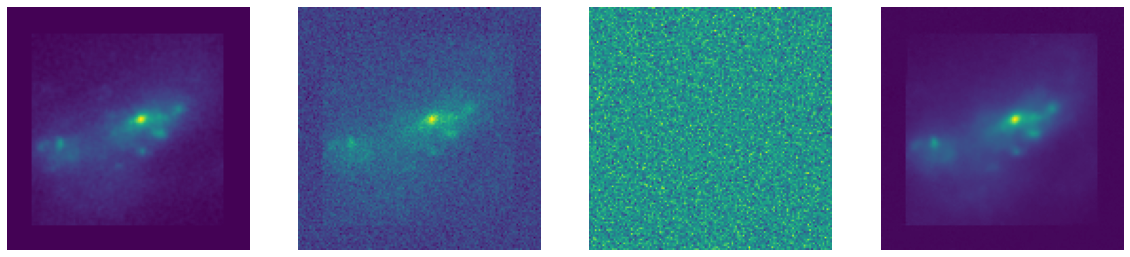

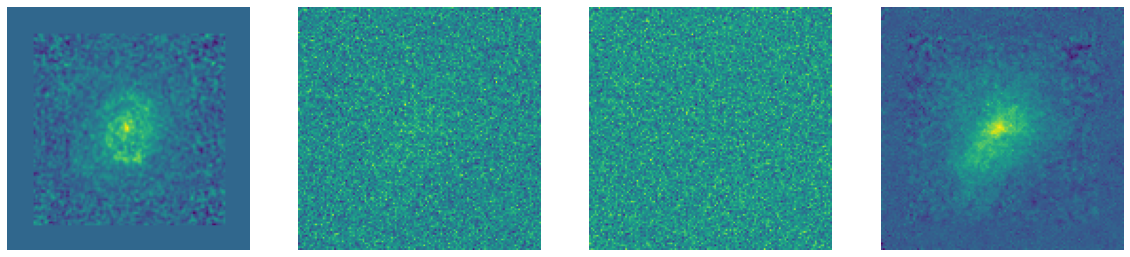

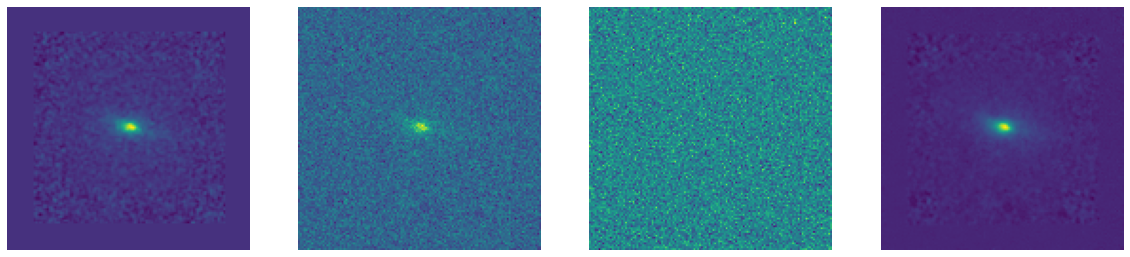

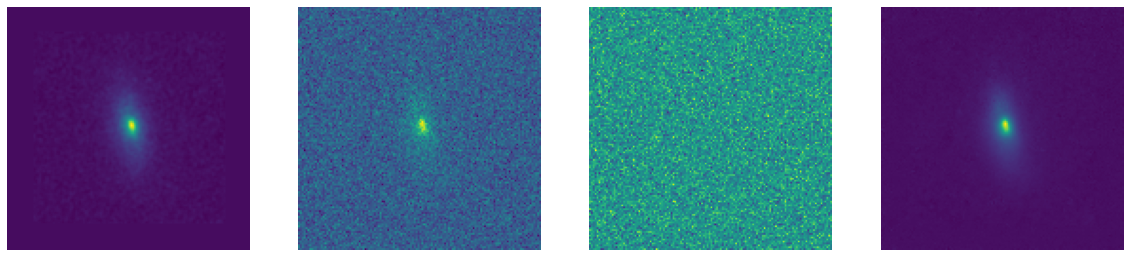

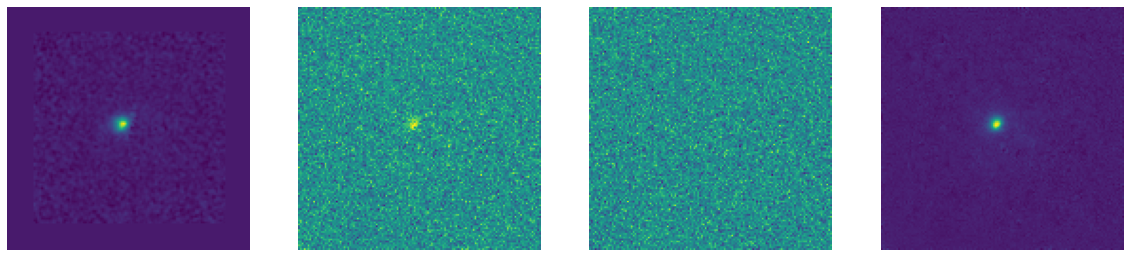

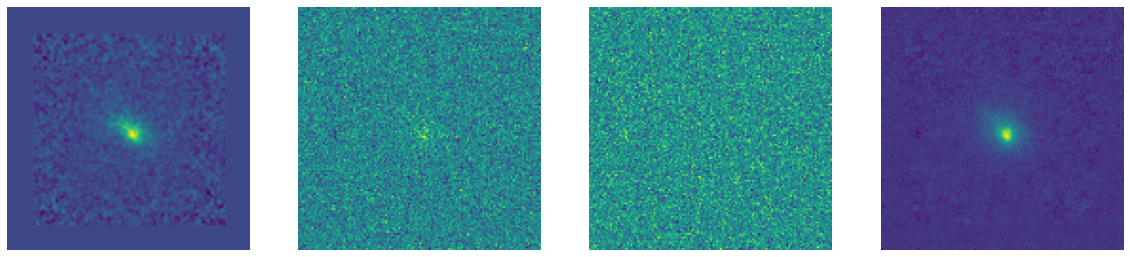

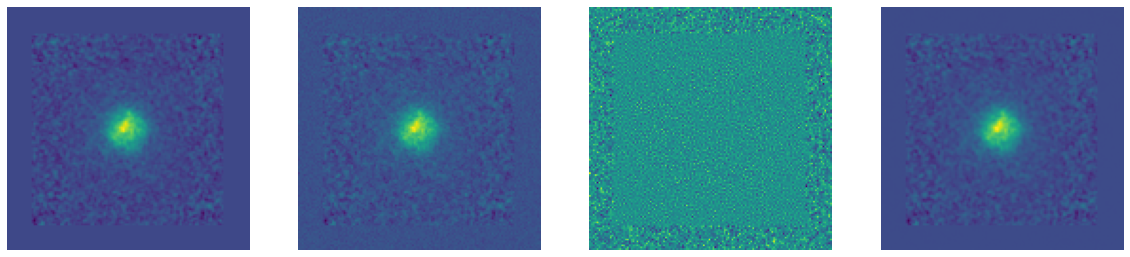

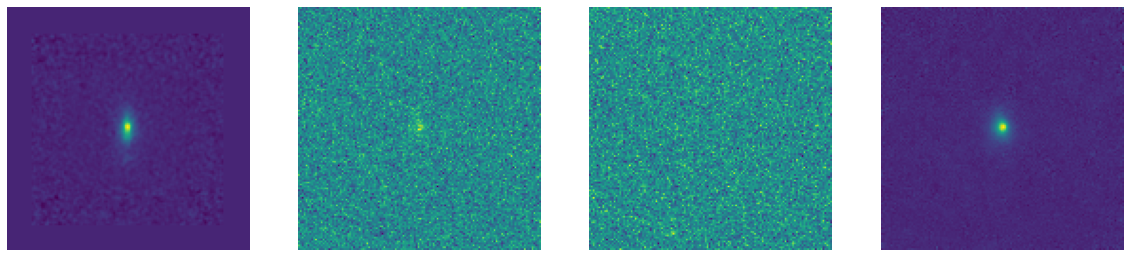

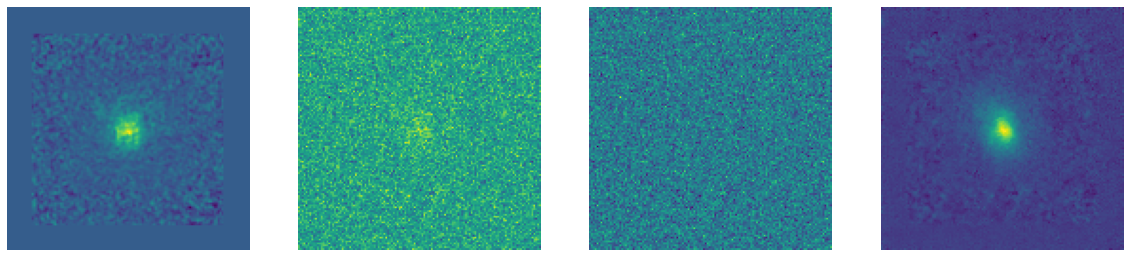

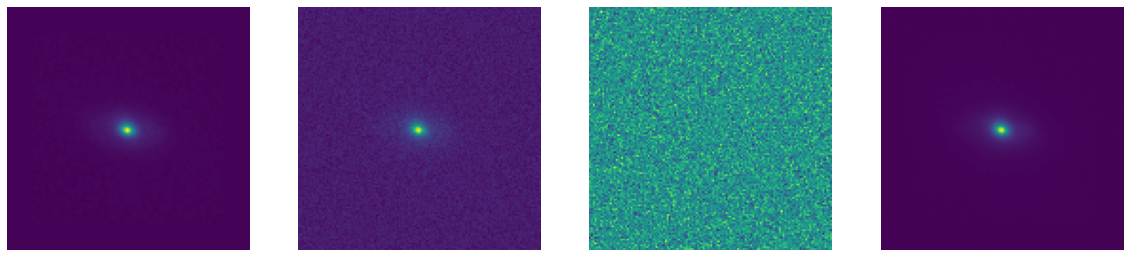

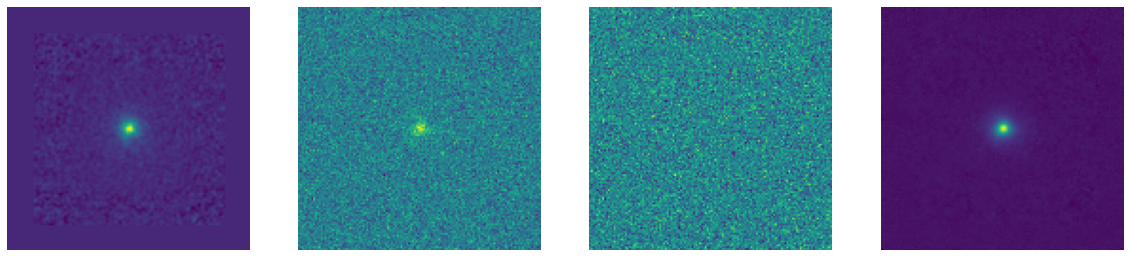

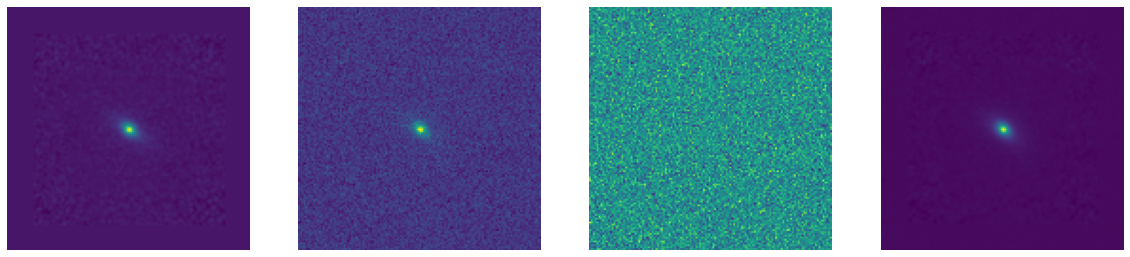

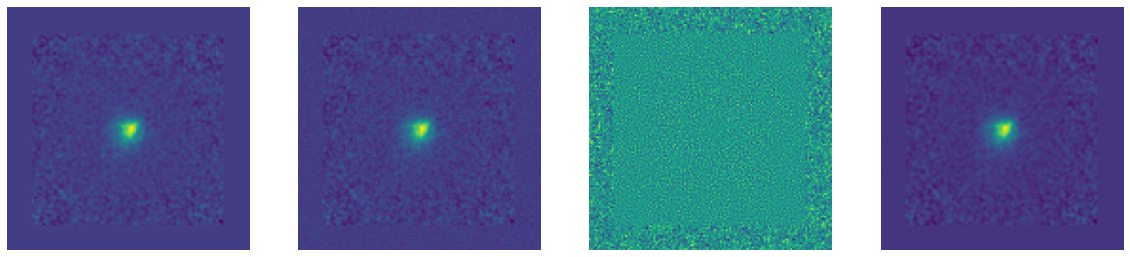

In [626]:
for i in range(16):
    figure(figsize=[20,5])
    subplot(141)
    imshow(batch['x'][i])
    axis('off')
    subplot(142)
    imshow(batch['y'][i])
    axis('off')
    subplot(143)
    imshow(score[i])
    axis('off')
    subplot(144)
    imshow(batch['y'][i] + (batch['s']**2 * score)[i])
    axis('off')

In [ ]:
# with open('score_model_0.05/model-%d.pckl'%step, 'rb') as file:
#     params, state, sn_state = pickle.load(, file)

In [815]:
from scipy import integrate

@jax.jit
def score_fn(y, s):
    score, _ = model.apply(params, state, None, y, s.reshape((-1,1,1,1)), is_training=False)
    return score

@jax.jit
def dynamics(t, x):
  x = x.reshape([-1,128,128,1])
  return - 0.5*score_fn(x, s=jnp.ones([1])*jnp.sqrt(t)).reshape([-1])

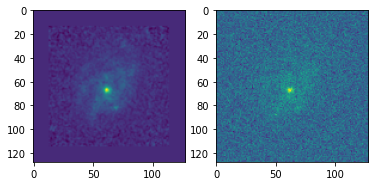

In [817]:
subplot(121)
imshow(batch['x'][0] )
subplot(122)
imshow(batch['y'][0] )

In [933]:
noise = 0.2
init_image = batch['y'][0] + noise*randn(1,128,128,1)

In [934]:
start_and_end_times = jnp.logspace(log10(0.99*noise**2),-7)

solution = integrate.solve_ivp(dynamics, 
                               [noise**2,(0.0)], 
                               init_image.flatten(),
                               t_eval=start_and_end_times)

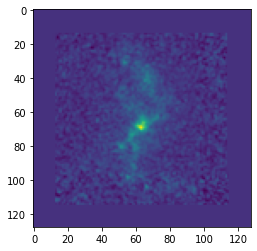

In [935]:
imshow(solution.y[:,-1].reshape(128,128))